In [16]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [17]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# plots accuracy and loss curves
# def plot_model_history(model_history):
#     """
#     Plot Accuracy and Loss curves given the model_history
#     """
#     fig, axs = plt.subplots(1,2,figsize=(15,5))
#     # summarize history for accuracy
#     axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
#     axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
#     axs[0].set_title('Model Accuracy')
#     axs[0].set_ylabel('Accuracy')
#     axs[0].set_xlabel('Epoch')
#     axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
#     axs[0].legend(['train', 'val'], loc='best')
#     # summarize history for loss
#     axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
#     axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
#     axs[1].set_title('Model Loss')
#     axs[1].set_ylabel('Loss')
#     axs[1].set_xlabel('Epoch')
#     axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
#     axs[1].legend(['train', 'val'], loc='best')
#     fig.savefig('plot.png')
#     plt.show()

In [18]:
# Generate data paths with labels
def generate_data_path(dir): 
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one dataframe
    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

## 1. Data Processing

In [19]:
# Define data generators
train_dir = 'data/train'
val_dir = 'data/test'
test_dir = 'data/test'

num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

In [20]:
# Generate train and test data path
train_df = generate_data_path(train_dir)
test_df = generate_data_path(test_dir)

In [21]:
train_df

,filepaths,labels
0,data/train\angry\Training_10118481.jpg,angry
1,data/train\angry\Training_10120469.jpg,angry
2,data/train\angry\Training_10131352.jpg,angry
3,data/train\angry\Training_10161559.jpg,angry
4,data/train\angry\Training_1021836.jpg,angry
...,...,...
28704,data/train\surprise\Training_99916297.jpg,surprise
28705,data/train\surprise\Training_99924420.jpg,surprise
28706,data/train\surprise\Training_99937001.jpg,surprise
28707,data/train\surprise\Training_99951755.jpg,surprise


In [22]:
test_df

,filepaths,labels
0,data/test\angry\PrivateTest_10131363.jpg,angry
1,data/test\angry\PrivateTest_10304478.jpg,angry
2,data/test\angry\PrivateTest_1054527.jpg,angry
3,data/test\angry\PrivateTest_10590091.jpg,angry
4,data/test\angry\PrivateTest_1109992.jpg,angry
...,...,...
7173,data/test\surprise\PublicTest_98089595.jpg,surprise
7174,data/test\surprise\PublicTest_98567249.jpg,surprise
7175,data/test\surprise\PublicTest_98972870.jpg,surprise
7176,data/test\surprise\PublicTest_99242645.jpg,surprise


## Splitting the DataFrame

In [23]:
# valid and test dataframe
train_df, valid_df = train_test_split(train_df,  train_size = 0.6, shuffle = True, random_state = 2024)

In [24]:
train_df

,filepaths,labels
25511,data/train\sad\Training_9958482.jpg,sad
24263,data/train\sad\Training_75543932.jpg,sad
24297,data/train\sad\Training_76247539.jpg,sad
546,data/train\angry\Training_22417394.jpg,angry
4232,data/train\disgust\Training_61376133.jpg,disgust
...,...,...
14875,data/train\happy\Training_88926203.jpg,happy
2688,data/train\angry\Training_71075038.jpg,angry
19040,data/train\neutral\Training_69374744.jpg,neutral
19962,data/train\neutral\Training_86553914.jpg,neutral


In [25]:
valid_df

,filepaths,labels
17818,data/train\neutral\Training_47181716.jpg,neutral
12072,data/train\happy\Training_54117536.jpg,happy
17264,data/train\neutral\Training_37319440.jpg,neutral
26469,data/train\surprise\Training_36388968.jpg,surprise
102,data/train\angry\Training_12604769.jpg,angry
...,...,...
18905,data/train\neutral\Training_66899804.jpg,neutral
2007,data/train\angry\Training_55165674.jpg,angry
16775,data/train\neutral\Training_27856367.jpg,neutral
13060,data/train\happy\Training_66812819.jpg,happy


## Image Data Generator

In [26]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 17225 validated image filenames belonging to 7 classes.
Found 11484 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


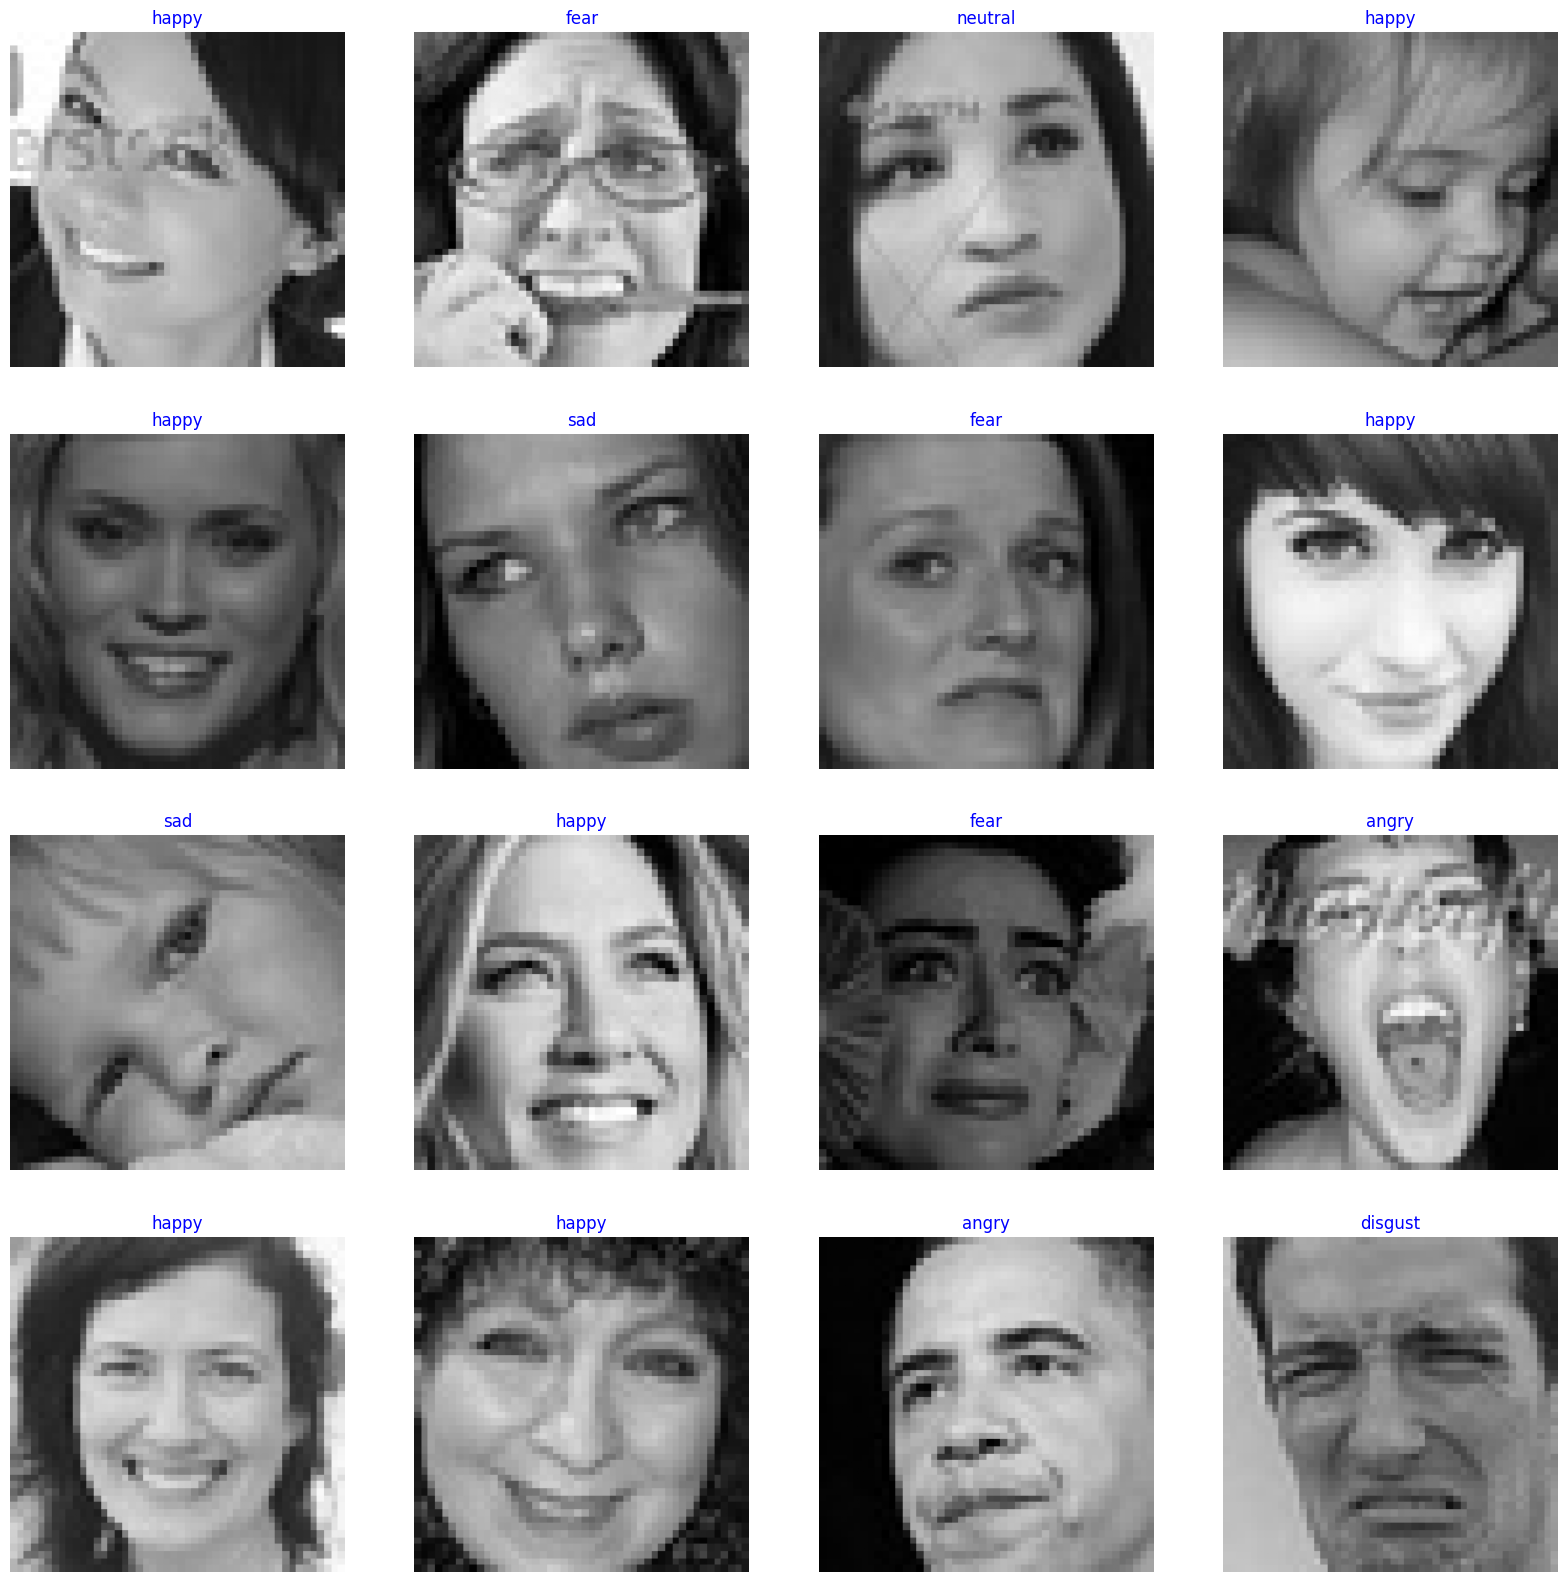

In [27]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

## Model Structure

In [28]:
#Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [ ]:
# # Create the model
# model = Sequential()

# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(7, activation='softmax'))

## Model Fitting

In [ ]:
# model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001, decay=1e-6),metrics=['accuracy'])
# model_info = model.fit(
#         train_generator,
#         steps_per_epoch=num_train // batch_size,
#         epochs=num_epoch,
#         validation_data=validation_generator,
#         validation_steps=num_val // batch_size)
# # plot_model_history(model_info)
# model.save_weights('model.weights.h5')


In [ ]:
batch_size = 20   # set batch size for training
epochs =  10  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

## Evaluate Model

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

## Predictions

preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

## Confusion Matrix

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
model.save("model.h5")